In [1]:
## Note: DUE TO RANDOM INITIALIZATION OF WEIGHTS IN A NEURAL NETWORK, THE OUTPUTS CAN BE DIFFERENT FOR EVERY RUN OF THE MODEL.
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import keras
import numpy as np

In [2]:
## Loading datasets
temperature_dataset = pd.read_csv("data/temperature/GlobalLandTemperaturesByCountry.csv")
co2_emissions_dataset = pd.read_csv("data/co2 emissions/2- annual-co-emissions-by-region.csv")
crops_dataset = pd.read_csv("data/crops/Crops_AllData_Normalized.csv", encoding='latin1')
## Pre-process temperature dataset
temperature_dataset['Year'] = pd.DatetimeIndex(temperature_dataset['dt']).year
temperature_dataset = temperature_dataset.drop(["dt","AverageTemperatureUncertainty"], axis= 1)
temperature_dataset = temperature_dataset.dropna()
temperature_dataset = temperature_dataset.groupby(["Country", "Year"])["AverageTemperature"].mean().reset_index()
## Pre-process co2 emission dataset
co2_emissions_dataset = co2_emissions_dataset.drop("Code", axis = 1)
co2_emissions_dataset = co2_emissions_dataset.dropna()
co2_emissions_dataset = co2_emissions_dataset.rename(columns = {"Entity": "Country"})
## Pre-process crops dataset
crops_dataset = crops_dataset.drop(['Area Code', 'Year Code', 'Item Code', 'Element Code', 'Flag'], axis = 1)
crops_dataset = crops_dataset.dropna()
crops_dataset = crops_dataset.rename(columns = {"Area": "Country"})
crops_dataset = crops_dataset[crops_dataset["Element"] != "Yield"]
crops_dataset = crops_dataset.drop("Unit", axis = 1)
crops_dataset = crops_dataset.pivot(index = ["Country", "Item", "Year"], columns = "Element", values = "Value").reset_index()
## Create aggregate dataset based on year and country
aggregate_dataset = pd.merge(temperature_dataset, co2_emissions_dataset, on = ["Country", "Year"], how = 'inner')
aggregate_dataset = pd.merge(aggregate_dataset, crops_dataset, on = ["Country", "Year"], how = "inner")
aggregate_dataset = aggregate_dataset.dropna().reset_index(drop=True)
aggregate_dataset_copy = aggregate_dataset.copy()

In [3]:
## Divide feature space
categorical_features = ['Country', 'Item']
continuous_features = ['Year']
target_features = ['Annual CO₂ emissions', 'AverageTemperature', 'Area harvested', 'Production']
## Prepare categorical features for processing
for feature in categorical_features:
    aggregate_dataset[feature] = aggregate_dataset[feature].astype('category').cat.codes
## Divide dataset into input and output features
X_categorical = aggregate_dataset[categorical_features].values
X_continuous = aggregate_dataset[continuous_features].values
y = aggregate_dataset[target_features].values
## Scale the continuous input features
scaler = StandardScaler()
X_continuous = scaler.fit_transform(X_continuous)
## Prepare each target feature separately for scaling [Note that in this problem, all the target features are continuous]
y_co2 = y[:, 0].reshape(-1, 1)
y_temp = y[:, 1].reshape(-1, 1)
y_area = y[:, 2].reshape(-1, 1)
y_production = y[:, 3].reshape(-1, 1)
## Apply log transform for targets that have a huge range of values to reduce the range (helps in improving model performance)
y_co2_log = np.log1p(y_co2)
y_area_log = np.log1p(y_area)
y_production_log = np.log1p(y_production)
## Create scalers for each output feature, which will be used to inverse scale for predictions
scaler_co2 = StandardScaler()
scaler_temp = StandardScaler()
scaler_area = StandardScaler()
scaler_production = StandardScaler()
## Scale the output features individually.
y_co2_scaled = scaler_co2.fit_transform(y_co2_log)
y_temp_scaled = scaler_temp.fit_transform(y_temp)
y_area_scaled = scaler_area.fit_transform(y_area_log)
y_production_scaled = scaler_production.fit_transform(y_production_log)
## Combine the scaled output features
y_scaled = np.hstack([y_co2_scaled, y_temp_scaled, y_area_scaled, y_production_scaled])
## Split the dataset into training and test datasets
X_categorical_train, X_categorical_test, X_continuous_train, X_continuous_test, y_train, y_test = train_test_split(
    X_categorical, X_continuous, y_scaled, test_size=0.2, random_state=42
)
## Define values required for embedding categorical features
num_countries = aggregate_dataset['Country'].nunique()
num_items = aggregate_dataset['Item'].nunique()
embedding_dim = 10
## Create input objects for each input feature
country_input = keras.Input(shape=(1,), name='country_input')
item_input = keras.Input(shape=(1,), name='item_input')
year_input = keras.Input(shape=(1, ), name='year_input')
## Create embeddings for categorical input features and flatten the embedding vectors
country_embedding = keras.layers.Embedding(input_dim=num_countries, output_dim=embedding_dim)(country_input)
country_embedding = keras.layers.Flatten()(country_embedding)
item_embedding = keras.layers.Embedding(input_dim=num_items, output_dim=embedding_dim)(item_input)
item_embedding = keras.layers.Flatten()(item_embedding)
## Create dense layers for year, as it is a continuous feature and is expected to have a non-linear relationship with the targets
year_dense = keras.layers.Dense(16, activation='relu')(year_input)
year_dense = keras.layers.Dense(16, activation='relu')(year_dense)
## Combine the inputs into a single layer
combined_features = keras.layers.Concatenate()([country_embedding, item_embedding, year_dense])
## Create hidden dense layers to learn relations and correlation between features.
shared_representation1 = tf.keras.layers.Dense(64, activation='relu')(combined_features)
shared_representation2 = tf.keras.layers.Dense(64, activation='relu')(shared_representation1)
shared_representation3 = tf.keras.layers.Dense(64, activation='relu')(shared_representation2)
shared_representation4 = tf.keras.layers.Dense(64, activation='relu')(shared_representation3)

## Use the learnings from hidden layers to get the values for target features
'''
Based on experimentation with various network architectures, it was found that :
1. co2 feature learns better from the 2nd layer (Reduced MAE)
2. temperature feature learns better from the 1st layer (Reduced MAE)
3. Area and production are features that are highly dependent on the other features and exhibit better modelling when
   using the outputs of the 4th layer.
'''
co2_output = keras.layers.Dense(1, name = 'co2_output')(shared_representation2) 
temp_output = keras.layers.Dense(1, name = 'temp_output')(shared_representation1)
area_output = keras.layers.Dense(1, name = 'area_output')(shared_representation4)
production_output = keras.layers.Dense(1, name = 'production_output')(shared_representation4)

## Create the nerual network architecture
model = tf.keras.Model(inputs=[country_input, item_input, year_input], outputs = [co2_output, temp_output, area_output, production_output])
## Define the model and the parameters
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae', 'mae', 'mae', 'mae'])
## Split the input features for training and test datasets for readability in code while fitting the model
train_country = X_categorical_train[:, 0]
train_item = X_categorical_train[:, 1]
train_year = X_continuous_train[:, 0]
test_country = X_categorical_test[:, 0]
test_item = X_categorical_test[:, 1]
test_year = X_continuous_test[:, 0]

history = model.fit(
    [train_country, train_item, train_year],
    [y_train[:, 0], y_train[:, 1], y_train[:, 2], y_train[:, 3]],
    validation_data = (
        [test_country, test_item, test_year],
        [y_test[:, 0], y_test[:, 1], y_test[:, 2], y_test[:, 3]]
    ),
    epochs = 100,
    batch_size = 32
)

Epoch 1/100
10175/10175 ━━━━━━━━━━━━━━━━━━━━ 7s 633us/step - area_output_loss: 0.3795 - area_output_mae: 0.4592 - co2_output_loss: 0.0893 - co2_output_mae: 0.1664 - loss: 0.9333 - production_output_loss: 0.3856 - production_output_mae: 0.4583 - temp_output_loss: 0.0789 - temp_output_mae: 0.1254 - val_area_output_loss: 0.2297 - val_area_output_mae: 0.3511 - val_co2_output_loss: 0.0279 - val_co2_output_mae: 0.1035 - val_loss: 0.5097 - val_production_output_loss: 0.2460 - val_production_output_mae: 0.3618 - val_temp_output_loss: 0.0060 - val_temp_output_mae: 0.0604
Epoch 2/100
10175/10175 ━━━━━━━━━━━━━━━━━━━━ 6s 625us/step - area_output_loss: 0.2046 - area_output_mae: 0.3349 - co2_output_loss: 0.0253 - co2_output_mae: 0.1025 - loss: 0.4423 - production_output_loss: 0.2061 - production_output_mae: 0.3324 - temp_output_loss: 0.0063 - temp_output_mae: 0.0620 - val_area_output_loss: 0.1668 - val_area_output_mae: 0.3028 - val_co2_output_loss: 0.0227 - val_co2_output_mae: 0.0961 - val_loss: 0.3

In [4]:
## Evaluate the model on test dataset
model.evaluate([test_country, test_item, test_year], [y_test[:, 0], y_test[:, 1], y_test[:, 2], y_test[:, 3]])

2544/2544 ━━━━━━━━━━━━━━━━━━━━ 2s 597us/step - area_output_loss: 0.0556 - area_output_mae: 0.1682 - co2_output_loss: 0.0141 - co2_output_mae: 0.0744 - loss: 0.1332 - production_output_loss: 0.0597 - production_output_mae: 0.1751 - temp_output_loss: 0.0038 - temp_output_mae: 0.0472


[0.13429272174835205,
 0.015136109665036201,
 0.0037826774641871452,
 0.055692121386528015,
 0.05967947468161583,
 0.16813576221466064,
 0.07489585131406784,
 0.1747533082962036,
 0.047166671603918076]

In [5]:
def predict(country, item, year):
    ## Encode the categorical inputs
    country_encoded = np.array([[aggregate_dataset_copy['Country'].astype('category').cat.categories.get_loc(country)]])
    item_encoded = np.array([[aggregate_dataset_copy['Item'].astype('category').cat.categories.get_loc(item)]])
    ## Scale the year input feature
    year_normalized = scaler.transform(np.array([[year]]))
    ## Predict
    y_pred_scaled = model.predict([country_encoded, item_encoded, year_normalized], verbose = False)
    ## Retrieve values form the aggregate prediction
    y_co2_pred_scaled = y_pred_scaled[0]
    y_temp_pred_scaled = y_pred_scaled[1]
    y_area_pred_scaled = y_pred_scaled[2]
    y_production_pred_scaled = y_pred_scaled[3]
    ## Perform inverse scaling to arrive at the actual scale of predictions that align with the inputs
    y_co2_pred_log = scaler_co2.inverse_transform(y_co2_pred_scaled)
    y_temp_pred = scaler_temp.inverse_transform(y_temp_pred_scaled)
    y_area_pred_log = scaler_area.inverse_transform(y_area_pred_scaled)
    y_production_pred_log = scaler_production.inverse_transform(y_production_pred_scaled)
    # Perform inverse transformation to arrive at the actual values of the predictions
    y_co2_pred = np.expm1(y_co2_pred_log)
    y_area_pred = np.expm1(y_area_pred_log)
    y_production_pred = np.expm1(y_production_pred_log)
    return {
        "Annual CO₂ emissions": y_co2_pred[0][0],
        "AverageTemperature": y_temp_pred[0][0],
        "Area harvested": y_area_pred[0][0],
        "Production": y_production_pred[0][0]
    }

In [6]:
import matplotlib.pyplot as plt

def visualize_feature_predictions(feature):
    actual_values = []
    predicted_values = []
    for i in range(100): # Gather 100 datapoints
        actual_value = aggregate_dataset_copy[feature][i*800] # Jump ahead to avoid gathering instances that are closely related due to sorting
        actual_values.append(actual_value)
        prediction = predict(aggregate_dataset_copy['Country'][i*800], aggregate_dataset_copy['Item'][i*800], aggregate_dataset_copy['Year'][i*800])
        predicted_values.append(prediction[feature])
    plt.plot(range(100), actual_values, label = 'actual')
    plt.plot(range(100), predicted_values, label = 'predicted')
    plt.xlabel('Instance number')
    plt.ylabel(feature)
    plt.legend()

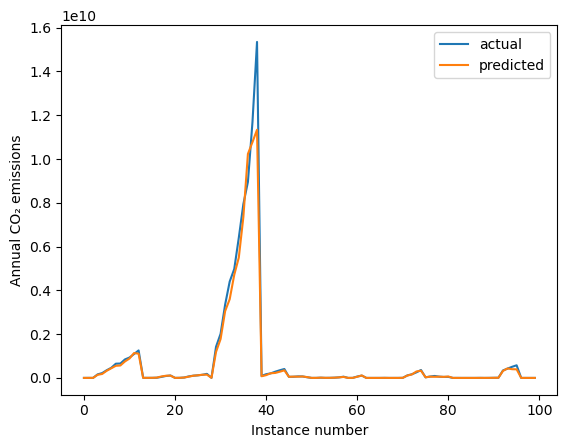

In [7]:
#Note: The graph may not show the best performance of the model, given that only some of the instances are evaluated in this
visualize_feature_predictions('Annual CO₂ emissions')

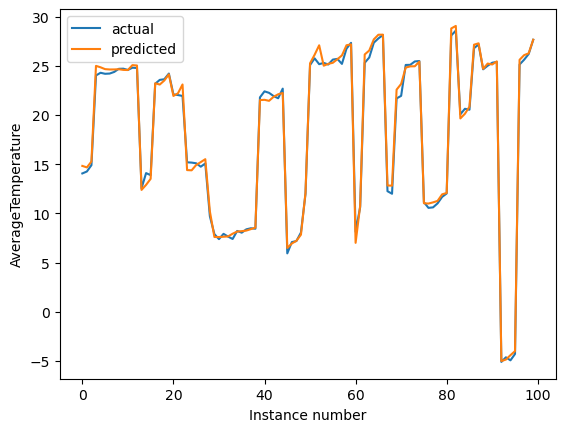

In [8]:
#Note: The graph may not show the best performance of the model, given that only some of the instances are evaluated in this
visualize_feature_predictions('AverageTemperature')

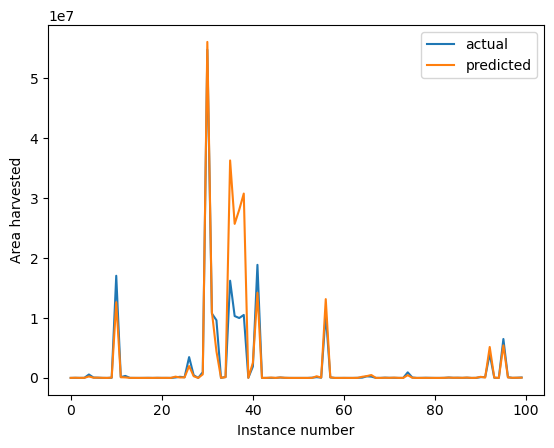

In [9]:
#Note: The graph may not show the best performance of the model, given that only some of the instances are evaluated in this
visualize_feature_predictions('Area harvested')

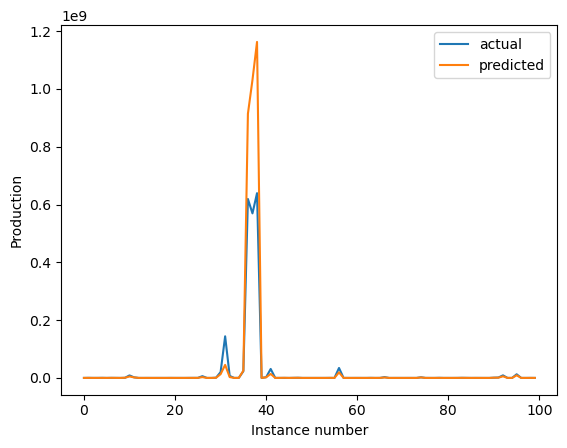

In [10]:
#Note: The graph may not show the best performance of the model, given that only some of the instances are evaluated in this
visualize_feature_predictions('Production')